# Intro
Name:  

    ORACLES_cld_CRE_v2

Purpose:  

    Build the cloud radiative effect input files from the cloud retrieval exported from ORACLES_cld_explore file
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - matplotlib
    - mpltools
    - numpy
    - scipy : for saving and reading
    - plotting_utils (user defined plotting routines)
    - hdf5storage
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 4STAR_cloud retrieval .mat files
  
 Modification History:
 
     Written: by Samuel LeBlanc, Bathurst, NB, 2017-01-06
     Modified: Samuel LeBlanc, Santa Cruz, CA, 2019-11-20
               - changed the file to load multiple aerosol models for CRE calculations

# Import of modules

In [1]:
import numpy as np
import hdf5storage as hs
import os
import write_utils as wu
import scipy.io as sio
from path_utils import getpath
import matplotlib.pyplot as plt

/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [55]:
from load_utils import load_from_json, mat2py_time,toutc

In [3]:
name = 'ORACLES'

In [4]:
vv = 'v5'
vr = 'R2'

In [23]:
fp_rtm = getpath('rtm')
fp_uvspec = getpath('uvspec_bin')+'uvspec'
fp = getpath('ORACLES')
fp_rtmdat = fp_rtm+'dat/'
matfile = fp+'{}_all_cld_ict.mat'.format(vr)
fp_uvspec_dat = getpath('uvspec_dat')

Return path named:  rtm /home/samuel/rtm/
Return path named:  uvspec_bin /mnt/c/Users/lebla/Research/libradtran/libRadtran-2.0.2/bin/
Return path named:  ORACLES /mnt/c/Users/lebla/Research/ORACLES/
Return path named:  uvspec_dat /mnt/c/Users/lebla/Research/libradtran/libRadtran-2.0.2/data/


## Set up for command line arguments

In [75]:
import argparse

In [76]:
long_description = """    Prepare the Cloud radiative effect files for calculations and thn save them using the doread argument"""

In [ ]:
parser = argparse.ArgumentParser(description=long_description)
parser.add_argument('-doread','--doread',help='if set, will only read the output, not produce them',
                    action='store_true')

In [ ]:
in_ = vars(parser.parse_args())
do_read = in_.get('doread',False)

# Load the saved files

## Load the cloud retrievals

In [6]:
 ar = hs.loadmat(fp+'zen_ict/{}/{}_all_cld_ict.mat'.format(vv,vr))

In [7]:
ar.keys()

[u'fl_alt',
 u'tau',
 u'ref_err',
 u'LWP',
 u'sza',
 u'lat_fl',
 u'lat',
 u'alt',
 u'tau_err_fl',
 u'lon_fl',
 u'tau_err',
 u'alt_fl',
 u'lon',
 u'tau_fl',
 u'LWP_err',
 u'LWP_err_fl',
 u'ref',
 u'ref_err_fl',
 u'fl_ki',
 u'utc_fl',
 u'LWP_fl',
 u'delta',
 u'phase',
 u'fl',
 u'fl_match',
 u'utc',
 u'ki',
 u'days',
 u'fl_incld',
 u'ref_fl']

In [8]:
dds = ['20160827','20160830','20160831','20160902','20160904','20160906','20160908',
       '20160910','20160912','20160914','20160918','20160920','20160924','20160925','20160927']

## Load the linked acaod values

In [9]:
aca = hs.loadmat(fp+'starzen/acaod_index_{}.mat'.format(vv))

In [10]:
aca.keys()

[u'files', u'utc', u'acaod_index']

In [11]:
aca['files']

{u'0': 'ORACLES_lut_v5_05aod.txt',
 u'1': 'ORACLES_lut_v5_10aod.txt',
 u'2': 'ORACLES_lut_v5_15aod.txt',
 u'3': 'ORACLES_lut_v5_lowaod.txt',
 u'4': 'ORACLES_lut_v5_midaod.txt',
 u'5': 'ORACLES_lut_v5_65aod.txt',
 u'6': 'ORACLES_lut_v5_80aod.txt'}

(array([1406.,    0.,    0.,    0.,    0.,    0.,  234.,    0.,    0.,
         218.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

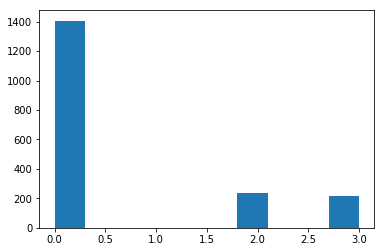

In [16]:
plt.figure()
plt.hist(aca['acaod_index']['20160904'])

# Prepare input files for radiative transfer

In [17]:
import Run_libradtran as Rl

## Prepare the defaults

In [21]:
from datetime import datetime
doy = datetime(int(dds[0][0:4]),int(dds[0][4:6]),int(dds[0][6:8])).timetuple().tm_yday

In [19]:
ar['days']

array([ 0.,  0.,  0., ..., 14., 14., 14.])

In [24]:
geo = {'lat':47.6212167,'lon':52.74245,'doy':doy,'zout':[0,1.5,100.0]}
aero_no = {} # none
cloud = {'ztop':1.0,'zbot':0.5,'write_moments_file':False}
source = {'wvl_range':[201.0,4000.0],'source':'solar','integrate_values':True,'run_fuliou':True,
          'dat_path':fp_uvspec_dat}
albedo = {'create_albedo_file':False,'sea_surface_albedo':True,'wind_speed':5.0}

In [27]:
cloud['phase'] = 'wc'
geo['sza'] = 40.0
cloud['tau'] = 2.0
cloud['ref'] = 5.0
pmom = Rl.make_pmom_inputs(fp_rtm=fp_rtmdat,source='solar')
cloud['moms_dict'] = pmom

In [28]:
phase_star = {0:'wc',1:'ic'}

In [29]:
phase_modis = {0:'wc',1:'wc',2:'ic',3:'ic',6:'wc'}

## Load the aerosol values

In [30]:
fp

u'/mnt/c/Users/lebla/Research/ORACLES/'

In [38]:
aca['aero'] = {}
for ka in aca['files'].keys():
    aa = load_from_json(fp+'/model/'+aca['files'][ka])
    aca['aero'][ka] = aa['aero']

In [39]:
aca['aero']['1']

OrderedDict([(u'ext',
              array([[0.19367598, 0.15301802, 0.1368469 , 0.1       , 0.06504064,
                      0.03515906, 0.02846083, 0.02665043, 0.02027237, 0.0121975 ,
                      0.00813167, 0.00406583],
                     [0.        , 0.        , 0.        , 0.        , 0.        ,
                      0.        , 0.        , 0.        , 0.        , 0.        ,
                      0.        , 0.        ]])),
             (u'wvl_arr',
              [200.0,
               350.0,
               400.0,
               500.0,
               650.0,
               875.0,
               980.0,
               1020.0,
               1240.0,
               1710.0,
               2410.0,
               4900.0]),
             (u'expand_hg', True),
             (u'disort_phase', False),
             (u'asy',
              array([[0.75      , 0.71      , 0.69      , 0.645     , 0.58      ,
                      0.52      , 0.512     , 0.51      , 0.49      , 0.45    

## Prepare the paths and files for input files

In [65]:
def isjupyter():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [40]:
# open the list file
f = open(fp_rtm+'{}_CRE_{}.sh'.format(name,vv),'w')
fpp_in = fp_rtm+'input/{}_CRE_{}/'.format(name,vv)
fpp_out = fp_rtm+'output/{}_CRE_{}/'.format(name,vv)

In [41]:
if not os.path.isdir(fpp_in):
    os.mkdir(fpp_in)
if not os.path.isdir(fpp_out):
     os.mkdir(fpp_out)

In [42]:
ar.keys()

[u'fl_alt',
 u'tau',
 u'ref_err',
 u'LWP',
 u'sza',
 u'lat_fl',
 u'lat',
 u'alt',
 u'tau_err_fl',
 u'lon_fl',
 u'tau_err',
 u'alt_fl',
 u'lon',
 u'tau_fl',
 u'LWP_err',
 u'LWP_err_fl',
 u'ref',
 u'ref_err_fl',
 u'fl_ki',
 u'utc_fl',
 u'LWP_fl',
 u'delta',
 u'phase',
 u'fl',
 u'fl_match',
 u'utc',
 u'ki',
 u'days',
 u'fl_incld',
 u'ref_fl']

In [43]:
ar['lat_fl'].shape

(3816,)

In [ ]:
if not do_read:

In [70]:
if isjupyter():
    from tqdm.notebook import tqdm 
    pbar = tqdm(total=len(ar['lat_fl']))

In [72]:
    # make input
    for i,l in enumerate(ar['lat_fl']):

        #print i

        f_in = '{name}_{vv}_star_{i:03d}_withaero.dat'.format(name=name,vv=vv,i=i)
        geo['lat'],geo['lon'],geo['sza'] = l,ar['lon_fl'][i],ar['sza'][ar['fl'].astype(bool)][i]
        day = dds[ar['days'][ar['fl'].astype(bool)][i].astype(int)]
        geo['doy'] = datetime(int(day[0:4]),int(day[4:6]),int(day[6:])).timetuple().tm_yday
        cloud['tau'],cloud['ref'] = ar['tau_fl'][i],ar['ref_fl'][i]
        cloud['write_moments_file'] = True

        i_aca = np.argmin(abs(aca['utc'][day]-ar['utc_fl'][i]))
        i_aero = '{}'.format(aca['acaod_index'][day][i_aca])
        
        Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aca['aero'][i_aero],cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

        f_in = '{name}_{vv}_star_{i:03d}_withaero_clear.dat'.format(name=name,vv=vv,i=i)
        cloud['tau'] = 0.0
        Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aca['aero'][i_aero],cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

        f_in = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
        cloud['tau'] = ar['tau_fl'][i]
        if cloud['ref']>25.0:
            cloud['write_moments_file'] = True
        else:
            cloud['write_moments_file'] = False
        Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero_no,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))

        f_in = '{name}_{vv}_star_{i:03d}_noaero_clear.dat'.format(name=name,vv=vv,i=i)
        cloud['tau'] = 0.0
        Rl.write_input_aac(fpp_in+f_in,geo=geo,aero=aero_no,cloud=cloud,source=source,albedo=albedo,
                                   verbose=False,make_base=False,set_quiet=True)
        f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uvspec,fin=fpp_in+f_in,out=fpp_out+f_in))
        if isjupyter(): 
            pbar.update(1)

    f.close()

wvl_range starting too low, setting to 250 nm


IndexError: index 432 is out of bounds for axis 0 with size 305

In [73]:
day

'20160830'

In [ ]:
else:

In [ ]:
# read output
    nstar = len(ar['lat_fl'])
    nz = len(geo['zout'])
    star_aero_CRE = {'dn':np.zeros((nstar,nz))+np.nan,'up':np.zeros((nstar,nz))+np.nan}
    star_aero_CRE_clear = {'dn':np.zeros((nstar,nz))+np.nan,'up':np.zeros((nstar,nz))+np.nan}
    star_aero_C = np.zeros((nstar,nz))+np.nan
    star_noaero_CRE = {'dn':np.zeros((nstar,nz))+np.nan,'up':np.zeros((nstar,nz))+np.nan}
    star_noaero_CRE_clear = {'dn':np.zeros((nstar,nz))+np.nan,'up':np.zeros((nstar,nz))+np.nan}
    star_noaero_C = np.zeros((nstar,nz))+np.nan

In [ ]:
# run through to read
    print '4STAR'
    for i,l in enumerate(ar['lat_fl']):
        print '\r{}..'.format(i)
        f_in = '{name}_{vv}_star_{i:03d}_withaero.dat'.format(name=name,vv=vv,i=i)
        s = Rl.read_libradtran(fpp_out+f_in,zout=geo['zout'])
        f_in = '{name}_{vv}_star_{i:03d}_withaero_clear.dat'.format(name=name,vv=vv,i=i)
        sc = Rl.read_libradtran(fpp_out+f_in,zout=geo['zout'])

        star_aero_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
        star_aero_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
        star_aero_CRE['up'][i,:] = s['diffuse_up']
        star_aero_CRE_clear['up'][i,:] = sc['diffuse_up']
        star_aero_C[i,:] = (star_aero_CRE['dn'][i,:]-star_aero_CRE['up'][i,:]) - \
                           (star_aero_CRE_clear['dn'][i,:]-star_aero_CRE_clear['up'][i,:])
        
        f_in = '{name}_{vv}_star_{i:03d}_noaero.dat'.format(name=name,vv=vv,i=i)
        sn = Rl.read_libradtran(fpp_out+f_in,zout=geo['zout'])
        f_in = '{name}_{vv}_star_{i:03d}_noaero_clear.dat'.format(name=name,vv=vv,i=i)
        snc = Rl.read_libradtran(fpp_out+f_in,zout=geo['zout'])

        star_noaero_CRE['dn'][i,:] = sn['diffuse_down']+sn['direct_down']
        star_noaero_CRE_clear['dn'][i,:] = snc['diffuse_down']+snc['direct_down']
        star_noaero_CRE['up'][i,:] = sn['diffuse_up']
        star_noaero_CRE_clear['up'][i,:] = snc['diffuse_up']
        star_noaero_C[i,:] = (star_noaero_CRE['dn'][i,:]-star_noaero_CRE['up'][i,:]) - \
                             (star_noaero_CRE_clear['dn'][i,:]-star_noaero_CRE_clear['up'][i,:])

In [ ]:
# save the output
    star1 = {'star_noaero_CRE':star_noaero_CRE,'star_noaero_CRE_clear':star_noaero_CRE_clear,'star_noaero_C':star_noaero_C,
            'star_aero_CRE':star_aero_CRE,'star_aero_CRE_clear':star_aero_CRE_clear,'star_aero_C':star_aero_C}
    star = wu.iterate_dict_unicode(star1)
    print 'saving file to: '+fp+'{name}_CRE_{vv}.mat'.format(name=name,vv=vv)
    hs.savemat(fp+'{name}_CRE_{vv}.mat'.format(name=name,vv=vv),star)
    #hs.savemat(fp+'{name}_CRE_{vv}.mat'.format(name=name,vv=vv),star_noaero_CRE,star_noaero_CRE_clear,star_noaero_C,
     #                                                           star_aero_CRE,star_aero_CRE_clear,star_aero_C)